In [1]:
!pip install -q keras-ocr

In [483]:
import keras_ocr
from matplotlib import pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_mean
from skimage.filters import threshold_otsu

from skimage.util import invert
from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.filters import gaussian
from scipy.ndimage import interpolation as inter
import scipy

In [3]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/iduadmin/.keras-ocr/craft_mlt_25k.h5


2023-01-20 09:20:32.828848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 09:20:32.871100: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/iduadmin/miniconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-20 09:20:32.871117: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-20 09:20:32.871434: I tensorflow/core/pla

Looking for /home/iduadmin/.keras-ocr/crnn_kurapan.h5


In [631]:
image = cv2.imread('../Task3_images/car/NK09 FJY.jpeg', -1)
img = cv2.resize(image, None, fx=2, fy=1.5)

In [641]:
# Remove shadows
rgb_planes = cv2.split(img)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    result_planes.append(diff_img)
    
result = cv2.merge(result_planes)
result = cv2.fastNlMeansDenoisingColored(result, None, 1, 10, 7, 15) 

cv2.imwrite("no_shadow.png", result)
image = imread("no_shadow.png")

image = gaussian(image)

gray_img = rgb2gray(image)
thresh = threshold_mean(gray_img)
binary = invert(gray_img < thresh)

# binary = gaussian(binary)

# blur = cv2.bilateralFilter(binary,9,75,75)

imsave("binary_blur2.png", binary)
# print(thresh)
# plt.figure(figsize=(20,20))
# plt.axis("off")
# plt.imshow(binary, cmap="gray")
# plt.savefig("binary_blur.png")

/tmp/ipykernel_491104/3593401520.py:28: UserWarning: binary_blur2.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave("binary_blur2.png", binary)


1/1 [==============================] - 1s 694ms/step


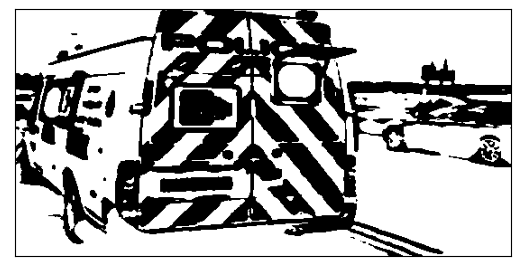

[]


In [642]:
paths = 'binary_blur2.png'
image = keras_ocr.tools.read(paths)
prediction = pipeline.recognize([image])[0]
fig, ax = plt.subplots()
keras_ocr.tools.drawAnnotations(image=image, predictions=prediction, ax=ax)
plt.show()
print(prediction)


In [601]:
height_variation = 2 # +/- half of overall height to buffer

line = {}
y_buffer = 0
prev_y_max = 0
prev_y_min = 0
complete = ""

for text, box in prediction:
    y_max = box[:, 1].max()
    y_min = box[:, 1].min()
    x_min = box[:, 0].min()
    print(box)
    if (prev_y_min - y_buffer) < y_min and (prev_y_max + y_buffer) > y_max:
        prev_y_min = y_min
        y_buffer = (y_max - y_min) / height_variation
        prev_y_max = y_max
        line[x_min] = text
    else:
        line = dict(sorted(line.items()))
        words = ''
        for word in line.values():
            words = words + ' ' + word

        complete = complete + words + '\n'
        line = {x_min:text}
        prev_y_min = y_min
        prev_y_max = y_max
        y_buffer = (y_max - y_min) / height_variation

print(complete)



[[ 871.2711   763.63196]
 [1019.05536  829.9841 ]
 [ 985.5889   904.523  ]
 [ 837.8047   838.1709 ]]
[[1031.5105   832.55743]
 [1189.1619   909.7744 ]
 [1149.0575   991.6542 ]
 [ 991.40607  914.4372 ]]
[[1724.6094 1515.625 ]
 [1796.875  1515.625 ]
 [1796.875  1595.7031]
 [1724.6094 1595.7031]]

 bniz
 rmz



In [637]:
from difflib import SequenceMatcher
from mod_keras import KerasModel
import os

model = KerasModel()
count = 0
h_count = 0
total = 0
path_to_images = "../Task3_images/car/"
for root, dirs, file_names in os.walk(path_to_images):
    for file_name in file_names:
        
        
        output = KerasModel.get_text(model, str(path_to_images + file_name))

        reference = str('\n ' + file_name.split('.')[0].lower()+"\n")


        # candidate = 'Hello my name is Leonie'
        # print('BLEU score:', (sentence_bleu(reference, output["text"]))*100)

        s = SequenceMatcher(None, reference.lower(), output["text"].lower())
        
        print(reference)
        print(output["text"].lower())        
        print(s.ratio()*100)

        total = total + (s.ratio()*100)
        count = count + 1

        if s.ratio()*100 == 100:
            h_count = h_count + 1
        
print("Average:", total / count)
print("100%:", (h_count / count) * 100)
print("Count:", count)

ModuleNotFoundError: No module named 'mod_keras'